# Comparing SVD Collaborative Filtering Methods

- Method 1: using cosine similarity between users reconstructed ratings matrix rows
- Method 2: using top residual values from reconstructed ratings matrix
- Comparison method: taking 5 random users and checking if domain recommendations are making sense related to their past purchases

Lucas A. Oliveira

---
### Setup

In [119]:
# Import necessary libraries
import string
from unidecode import unidecode
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
import session_info

In [120]:
# Display session information
session_info.show(html=False)

-----
PIL                         11.0.0
matplotlib                  3.9.2
numpy                       1.26.4
pandas                      2.2.3
scipy                       1.14.1
seaborn                     0.13.2
sentence_transformers       3.3.0
session_info                1.0.0
sklearn                     1.5.2
unidecode                   NA
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.2.5
notebook            7.2.2
-----
Python 3.12.6 (main, Sep  6 2024, 19:03:47) [Clang 15.0.0 (clang-1500.3.9.4)]
macOS-14.6.1-x86_64-i386-64bit
-----
Session information updated at 2024-11-13 11:02


---
### Load and Process Data

In [3]:
# Load the dataset
sample_items_meli = pd.read_csv('sample_items_meli.csv')

In [4]:
# Calculate the number of distinct categories
categorias_distintas = len(set(sample_items_meli['ITE_ITEM_DOM_DOMAIN_ID']))

In [5]:
# Remove domains with few orders using cumulative sum (threshold = 55%)
domain_vc = sample_items_meli.ITE_ITEM_DOM_DOMAIN_ID.value_counts().reset_index()
domain_vc.loc[:, "cum_sum"] = domain_vc.loc[:, "count"].cumsum()
domain_vc["%_acum"] = domain_vc.loc[:, "cum_sum"] / domain_vc.loc[:, "count"].sum()
domains_to_keep = domain_vc[domain_vc["%_acum"] <= 0.55]["ITE_ITEM_DOM_DOMAIN_ID"].values
sample_items_meli_mod = sample_items_meli[sample_items_meli.ITE_ITEM_DOM_DOMAIN_ID.isin(domains_to_keep)].reset_index(drop=True)

In [6]:
# Remove duplicate items from the dataset
sample_items_meli_mod = sample_items_meli_mod.drop_duplicates(subset='item_id')

---
### Analysis

In [7]:
# Creating user ratings matrix
df_user_domain = sample_items_meli_mod.pivot_table(
    index='buyer_ID',
    columns='ITE_ITEM_DOM_DOMAIN_ID',
    aggfunc='size',
    fill_value=0
)

In [8]:
df_user_domain.head()

ITE_ITEM_DOM_DOMAIN_ID,MLB-BACKPACKS,MLB-BICYCLES,MLB-BLOOD_GLUCOSE_METERS,MLB-BLOUSES,MLB-BODY_SHAPERS,MLB-BODY_SKIN_CARE_PRODUCTS,MLB-BOOTS_AND_BOOTIES,MLB-BRAS,MLB-CHARMS,MLB-DISHWASHING_DETERGENTS,...,MLB-SUPPLEMENTS,MLB-SWEATSHIRTS_AND_HOODIES,MLB-SWIMWEAR,MLB-THERMOSES,MLB-T_SHIRTS,MLB-UNDERPANTS,MLB-VINYL_ROLLS_AND_SHEETS,MLB-WALL_AND_CEILING_LIGHTS,MLB-WATER_HOSES,MLB-WRISTWATCHES
buyer_ID,,,,,,,,,,,,,,,,,,,,,
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2408,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Method calculating users similarity

In [9]:
# Perform SVD Decomposition
svd = TruncatedSVD(n_components=20, random_state=42)
truncated_matrix = svd.fit_transform(df_user_domain)

In [10]:
# Função para recomendar categorias baseadas em usuários similares e exibir as categorias já compradas
def recomendar_categorias(usuario_id, fatores_usuario, matriz_usuario_categoria, top_n=5):
    # Obtém o índice do usuário na matriz
    idx_usuario = matriz_usuario_categoria.index.get_loc(usuario_id)
    # Obtém o vetor de fatores do usuário
    vetor_usuario = fatores_usuario[idx_usuario].reshape(1, -1)
    # Calcula a similaridade coseno entre o usuário e todos os outros usuários
    similaridades = cosine_similarity(vetor_usuario, fatores_usuario)[0]
    # Ordena os usuários pela similaridade (excluindo o próprio usuário)
    idx_usuarios_similares = np.argsort(-similaridades)[1:]
    usuarios_similares = matriz_usuario_categoria.index[idx_usuarios_similares]
    # Soma as categorias compradas pelos usuários similares
    categorias = matriz_usuario_categoria.loc[usuarios_similares].sum()
    # Remove as categorias que o usuário já comprou
    categorias_usuario = matriz_usuario_categoria.loc[usuario_id]
    categorias_recomendar = categorias[categorias_usuario == 0]
    # Recomenda as top_n categorias
    categorias_recomendadas = categorias_recomendar.sort_values(ascending=False).head(top_n).index.tolist()
    
    # Filtra as categorias já compradas pelo usuário
    categorias_ja_compradas = categorias_usuario[categorias_usuario > 0].index.tolist()
    
    return categorias_recomendadas, categorias_ja_compradas

In [11]:
user_id = df_user_domain.index[0]
categorias_recomendadas, categorias_ja_compradas = recomendar_categorias(user_id, truncated_matrix, df_user_domain)

print(f"Categorias já compradas pelo usuário {user_id}:\n", categorias_ja_compradas)
print(f"Categorias recomendadas para o usuário {user_id}:\n", categorias_recomendadas)

Categorias já compradas pelo usuário 6:
 ['MLB-WATER_HOSES']
Categorias recomendadas para o usuário 6:
 ['MLB-SUPPLEMENTS', 'MLB-SNEAKERS', 'MLB-SANDALS_AND_CLOGS', 'MLB-HAIR_TREATMENTS', 'MLB-PANTS']


In [12]:
user_id = df_user_domain.index[1]
categorias_recomendadas, categorias_ja_compradas = recomendar_categorias(user_id, truncated_matrix, df_user_domain)

print(f"Categorias já compradas pelo usuário {user_id}:\n", categorias_ja_compradas)
print(f"Categorias recomendadas para o usuário {user_id}:\n", categorias_recomendadas)

Categorias já compradas pelo usuário 1375:
 ['MLB-SANDALS_AND_CLOGS']
Categorias recomendadas para o usuário 1375:
 ['MLB-SUPPLEMENTS', 'MLB-SNEAKERS', 'MLB-HAIR_TREATMENTS', 'MLB-PANTS', 'MLB-T_SHIRTS']


In [13]:
user_id = df_user_domain.index[2]
categorias_recomendadas, categorias_ja_compradas = recomendar_categorias(user_id, truncated_matrix, df_user_domain)

print(f"Categorias já compradas pelo usuário {user_id}:\n", categorias_ja_compradas)
print(f"Categorias recomendadas para o usuário {user_id}:\n", categorias_recomendadas)

Categorias já compradas pelo usuário 1380:
 ['MLB-WALL_AND_CEILING_LIGHTS']
Categorias recomendadas para o usuário 1380:
 ['MLB-SUPPLEMENTS', 'MLB-SNEAKERS', 'MLB-SANDALS_AND_CLOGS', 'MLB-HAIR_TREATMENTS', 'MLB-PANTS']


In [14]:
user_id = df_user_domain.index[3]
categorias_recomendadas, categorias_ja_compradas = recomendar_categorias(user_id, truncated_matrix, df_user_domain)

print(f"Categorias já compradas pelo usuário {user_id}:\n", categorias_ja_compradas)
print(f"Categorias recomendadas para o usuário {user_id}:\n", categorias_recomendadas)

Categorias já compradas pelo usuário 2408:
 ['MLB-BLOUSES', 'MLB-BODY_SHAPERS', 'MLB-BRAS', 'MLB-SHORTS']
Categorias recomendadas para o usuário 2408:
 ['MLB-SUPPLEMENTS', 'MLB-SNEAKERS', 'MLB-SANDALS_AND_CLOGS', 'MLB-HAIR_TREATMENTS', 'MLB-PANTS']


In [15]:
user_id = df_user_domain.index[4]
categorias_recomendadas, categorias_ja_compradas = recomendar_categorias(user_id, truncated_matrix, df_user_domain)

print(f"Categorias já compradas pelo usuário {user_id}:\n", categorias_ja_compradas)
print(f"Categorias recomendadas para o usuário {user_id}:\n", categorias_recomendadas)

Categorias já compradas pelo usuário 2593:
 ['MLB-ELECTRIC_OIL_DIFFUSERS_HUMIDIFIERS_AND_VAPORIZERS']
Categorias recomendadas para o usuário 2593:
 ['MLB-SUPPLEMENTS', 'MLB-SNEAKERS', 'MLB-SANDALS_AND_CLOGS', 'MLB-HAIR_TREATMENTS', 'MLB-PANTS']


#### Method using matrix reconstruction from SVD Decomposition

In [16]:
matrix_user_domain = df_user_domain.values
user_ratings_mean = np.mean(matrix_user_domain, axis = 1)
matrix_user_domain_demeaned = matrix_user_domain - user_ratings_mean.reshape(-1, 1)

In [18]:
# get SVD decompostion using only the top k singular values
U, sigma, Vt = svds(matrix_user_domain_demeaned, k = 20)
# Regenerate ratings martix using multiplication to get predictions
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_user_domain.columns)

In [63]:
def get_domains_recommendations(user_id, preds_df, sample_items_meli_mod, n_items_per_domain = 3, print_results = True):
    """ 
    For a given user ID and the reconstructed ratings matrix returns 'n_items_per_domain' items from each
    recommended domain to the user

    The recommended domains are the ones with big residual values after the rating matrix reconstruction (excluding the
    domains which the user already have orders)
    """
    # Get User shop historic
    sorted_user_predictions = preds_df.iloc[idx].sort_values(ascending=False)
    user_orders = sample_items_meli_mod[sample_items_meli_mod.buyer_ID == (user_id)]
    # Get predictions
    recommendations = sorted_user_predictions.reset_index()["ITE_ITEM_DOM_DOMAIN_ID"].values
    recommendations_list = [rec for rec in recommendations if rec not in user_orders.ITE_ITEM_DOM_DOMAIN_ID.values][:3]
    # Display recommendations
    if print_results:
        print(f"User ID {user_id} orders:")
        print()
        for row in user_orders.iterrows():
            print(f"Item ID: {row[1]['item_id']} - Item Title: {row[1]['ITE_ITEM_TITLE']} - Item Domain: {row[1]['ITE_ITEM_DOM_DOMAIN_ID']}")
        print("="*120)
        print(f"User ID {user_id} recommendations:")
        print()
        for domain in recommendations_list:
            print(f"Items reccomended for domain: {domain}")
            sample_domain = sample_items_meli_mod[sample_items_meli_mod.ITE_ITEM_DOM_DOMAIN_ID==domain].sample(n_items_per_domain, random_state=42).reset_index(drop=True)
            for i in range(n_items_per_domain):
                print(f"Item ID: {sample_domain.loc[i, "item_id"]} - Title: {sample_domain.loc[i, "ITE_ITEM_TITLE"]}")
            print("-"*120)

    return user_orders, recommendations_list

In [24]:
# Testing domain predictions for user
idx = 0
user_id = df_user_domain.index.values[idx]
_ = get_domains_recommendations(user_id, preds_df, sample_items_meli_mod)

User ID 6 orders:

Item ID: MLB3367081608 - Item Title: Mangueira Succao Azul 1 Pol - 10 Metros Isal - Item Domain: MLB-WATER_HOSES
User ID 6 recommendations:

Items reccomended for domain: MLB-HAIR_CLIPPERS_ELECTRIC_SHAVERS_AND_HAIR_TRIMMERS
Item ID: MLB3480257963 - Title: Kit Maquina Dragão Cabelo Barba E Aparador De Pelo De Nariz
Item ID: MLB4819753950 - Title: Maquina Para Depilar Pelos Do Corpo E Íntimos Kemei Km-1910
Item ID: MLB4931819342 - Title:  Kemei Km 2293
------------------------------------------------------------------------------------------------------------------------
Items reccomended for domain: MLB-HAIR_AND_FACE_DYES_AND_BLEACHES
Item ID: MLB3614260157 - Title: Oxidante Profissional Yellow Peroxide Yellow 90ml - Escolha
Item ID: MLB2897141725 - Title: Máscara Pigmentante Tonalizante Fantasia - Kamaleão Color
Item ID: MLB3808768033 - Title:  Tinta Para Barba E Bigode Castanho Escuro Delínea Men 15g
------------------------------------------------------------------

In [25]:
# Testing domain predictions for user
idx = 1
user_id = df_user_domain.index.values[idx]
_ = get_domains_recommendations(user_id, preds_df, sample_items_meli_mod)

User ID 1375 orders:

Item ID: MLB2619201839 - Item Title: Sandália Infantil Feminina Chinelo Flamingo Moda Slide 12.60 - Item Domain: MLB-SANDALS_AND_CLOGS
Item ID: MLB4194219408 - Item Title: Sandália Feminina Menina Moda Infantil Plataforma Promoção - Item Domain: MLB-SANDALS_AND_CLOGS
User ID 1375 recommendations:

Items reccomended for domain: MLB-HANDBAGS
Item ID: MLB3860920288 - Title: Bolsa Bag Pequena Masculino Couro Tiracolo Transversal Ombro
Item ID: MLB1858038528 - Title: Bolsa De Festa Clutch De Cristal Casamento Brilho Cetim 
Item ID: MLB3669483559 - Title: Bolsa Academia Mala Mão Viagem Transversal Blogueira Grande
------------------------------------------------------------------------------------------------------------------------
Items reccomended for domain: MLB-SWEATSHIRTS_AND_HOODIES
Item ID: MLB4830920316 - Title: Kit 2 Moletom Liso Feminino Blusa De Frio Casual Canguru
Item ID: MLB1626696254 - Title: Moletom Liso Masculino Flanelado Blusa De Frio Com Capuz
Item 

In [26]:
# Testing domain predictions for user
idx = 2
user_id = df_user_domain.index.values[idx]
_ = get_domains_recommendations(user_id, preds_df, sample_items_meli_mod)

User ID 1380 orders:

Item ID: MLB3751098364 - Item Title: Spot Trilho Duplo 2 Sobrepor Direcionável E-27 Branco 110v/220v - Item Domain: MLB-WALL_AND_CEILING_LIGHTS
User ID 1380 recommendations:

Items reccomended for domain: MLB-KITCHEN_SUPPLIES
Item ID: MLB1898113848 - Title: Porta Frios Inox 3 Peças Queijo Presunto Com Pinça Brinox
Item ID: MLB3048561078 - Title: Registro Botijão P13 P/ P2 /p5 /p8 - Transferidor Passa Gás 
Item ID: MLB3813976564 - Title: Suporte De Vassoura Montado Na Parede C/ Gancho P/ Organizar
------------------------------------------------------------------------------------------------------------------------
Items reccomended for domain: MLB-HOME_OFFICE_DESKS
Item ID: MLB3640843539 - Title: Mesa Em L Industrial Escrivaninha De Canto Nórdico Vintage Ferro E Madeira Laminada Com Preto E-led Meslmagn
Item ID: MLB3712565220 - Title: Mesa Em L P/ Escritório Diretor Estilo Industrrial 150x150
Item ID: MLB4138066348 - Title: Escrivaninha Mesa Apoio Lacamel Industr

In [27]:
# Testing domain predictions for user
idx = 3
user_id = df_user_domain.index.values[idx]
_ = get_domains_recommendations(user_id, preds_df, sample_items_meli_mod)

User ID 2408 orders:

Item ID: MLB2216734918 - Item Title: Top Bustier Fit Lupo Loba Sutia Faixa Sem Costura 44000 F - Item Domain: MLB-BRAS
Item ID: MLB3829274278 - Item Title: Kit 2 Croppeds Blusa Blusinha Feminina Regata Suplex Básica - Item Domain: MLB-BLOUSES
Item ID: MLB4512878758 - Item Title: Short Modelador Diminui Cintura Levanta Bumbum Original Lupo - Item Domain: MLB-BODY_SHAPERS
Item ID: MLB3925485572 - Item Title: Short Jeans Feminino Meia Coxa Cintura Alta Levanta Bumbum - Item Domain: MLB-SHORTS
User ID 2408 recommendations:

Items reccomended for domain: MLB-SOCKS
Item ID: MLB3632175795 - Title: Kit 6 Meias Lupo Masculinas Cano Médio Atacado Original
Item ID: MLB3318897483 - Title: Kit 12 Meia Infantil Escolar Tamanho 2 A 12 Anos Criança
Item ID: MLB3780667665 - Title: Meia Meião De Lã Inverno Frio Vovó 3/4 Cano Alto Até  Joelho
------------------------------------------------------------------------------------------------------------------------
Items reccomended for

In [28]:
# Testing domain predictions for user
idx = 4
user_id = df_user_domain.index.values[idx]
_ = get_domains_recommendations(user_id, preds_df, sample_items_meli_mod)

User ID 2593 orders:

Item ID: MLB3079601422 - Item Title: Umidificador Ar Portatil Ultrassonico Britania 2,4lts Bivolt - Item Domain: MLB-ELECTRIC_OIL_DIFFUSERS_HUMIDIFIERS_AND_VAPORIZERS
User ID 2593 recommendations:

Items reccomended for domain: MLB-HAIR_CLIPPERS_ELECTRIC_SHAVERS_AND_HAIR_TRIMMERS
Item ID: MLB3480257963 - Title: Kit Maquina Dragão Cabelo Barba E Aparador De Pelo De Nariz
Item ID: MLB4819753950 - Title: Maquina Para Depilar Pelos Do Corpo E Íntimos Kemei Km-1910
Item ID: MLB4931819342 - Title:  Kemei Km 2293
------------------------------------------------------------------------------------------------------------------------
Items reccomended for domain: MLB-HAIR_AND_FACE_DYES_AND_BLEACHES
Item ID: MLB3614260157 - Title: Oxidante Profissional Yellow Peroxide Yellow 90ml - Escolha
Item ID: MLB2897141725 - Title: Máscara Pigmentante Tonalizante Fantasia - Kamaleão Color
Item ID: MLB3808768033 - Title:  Tinta Para Barba E Bigode Castanho Escuro Delínea Men 15g
------

Observações:

- Os dois domínios "MLB-SUPPLEMENTS" e "MLB-SNEAKERS" estão aparecendo em todas recomendações do método de similaridade de cosseno, possivelmente relacionado ao fato de serem os dois domínios mais presentes no dataset
- Somente domínios presentes no Top 10 mais presentes estão contidos nas recomendações de similaridade
- 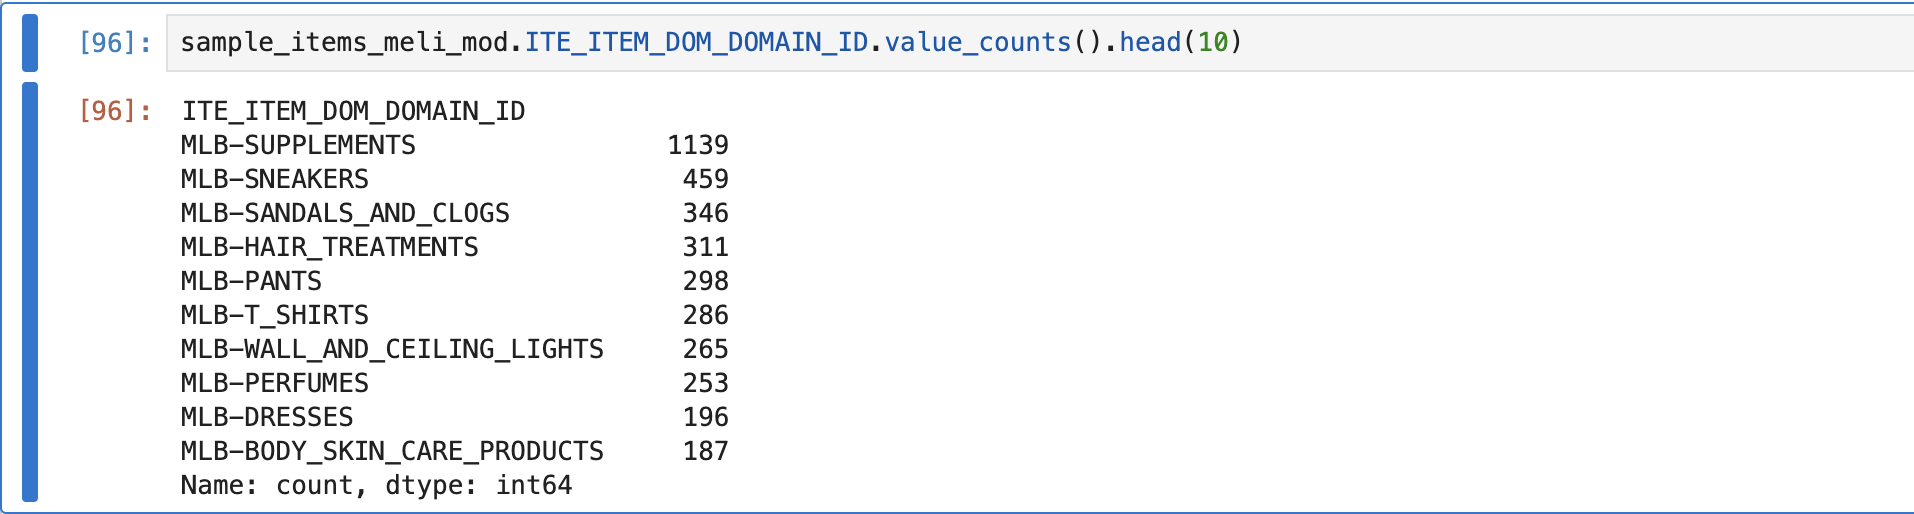
- As recomendações utilizando similaridade de cosseno não parecem se alterar com a variação do parâmetro k (número de valores singulares)
- Usuários com poucas compras acabam sendo um desafio para recomendar dado que sua linha na matrix de ratings é bastante esparsa
- As recomendações do método de resíduo parecem ter mais sentido (não em todos casos testados):
    - Para o usuário **1375**, que comprou duas sandálias infantis femininas foram recomendados itens de domínios relacionados a vestimenta/moda
    - Para o usuário **2408**, que comprou alguns itens de vestimenta a roupa íntima, foram sugeridos domínios de roupa íntima feminina e outros de vestimenta
    - Para o usuário **1380**, que adquiriu um item de decoração de casa, foram sugeridos itens de domínios relacionados a utensílios de cozinha, utensílios de jardinagem e móveis de escritório
- Dado isso, seguiremos com o **segundo método**, que parece dar recomendações mais próximas às ordens anteriores do usuários, além de ser possível otimizar as predições variando-se o número de valores singulares

#### Testing different number of singular values to get best recommendations

- Select a value **k** and reconstruct rating matrix
- Recommend **N** domains for all users
- Convert domains names to sentence embeddings
- Calculate cosine similarity between purchased domains and recommended domains
- Aggregate it for all users
- Repeat untill all values **k** are tested
- Select the **k** with bigger agg score 

In [29]:
model = SentenceTransformer("distiluse-base-multilingual-cased-v1")

In [30]:
def clean_domain(text):
    # remove MLB- from the beggining
    text = text[4:]
    # to lower case
    text = text.lower()
    # remove underscores and replace for \s
    text = text.replace("_", " ")

    return text

In [51]:
# process domain ID column text
sample_items_meli_mod.loc[:, "domain_normalized"] = sample_items_meli_mod.loc[:, "ITE_ITEM_DOM_DOMAIN_ID"].apply(clean_domain)
# Get unique domain names
domain_names = sample_items_meli_mod[["ITE_ITEM_DOM_DOMAIN_ID", "domain_normalized"]].drop_duplicates().reset_index(drop=True)
# generate embeddings for all domains names
embedding = model.encode(domain_names.domain_normalized.tolist())

In [129]:
# iterate over k's and users
k_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
agg_scores = []
for k in k_values:
    print(f">>> calculating for k = {k}...")
    similarities = []
    # get SVD decompostion using only the top k singular values
    U, sigma, Vt = svds(matrix_user_domain_demeaned, k = k)
    # Regenerate ratings martix using multiplication to get predictions
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_user_domain.columns)
    for idx in range(len(df_user_domain.index.values)):
        user_id = df_user_domain.index.values[idx]
        # Generate recommendations for user
        user_data, rec_list = get_domains_recommendations(user_id, preds_df, sample_items_meli_mod, print_results=False)
        # Get list of already purchased domains
        purc_list = user_data["ITE_ITEM_DOM_DOMAIN_ID"].to_list()
        # Get embeddings for purchased and recommended domains
        embs_purc = embeddings[domain_names["ITE_ITEM_DOM_DOMAIN_ID"].isin(purc_list)]
        embs_rec = embeddings[domain_names["ITE_ITEM_DOM_DOMAIN_ID"].isin(rec_list)]
        # Get max cosine similarity for each purchased domain
        cos_sim = list(cosine_similarity(embs_purc, embs_rec).max(axis=1))
        similarities.extend(cos_sim)
    # Calculate similarities mean and store it
    agg_scores.append(np.mean(similarities))

>>> calculating for k = 5...
>>> calculating for k = 10...
>>> calculating for k = 15...
>>> calculating for k = 20...
>>> calculating for k = 25...
>>> calculating for k = 30...
>>> calculating for k = 35...
>>> calculating for k = 40...
>>> calculating for k = 45...
>>> calculating for k = 50...


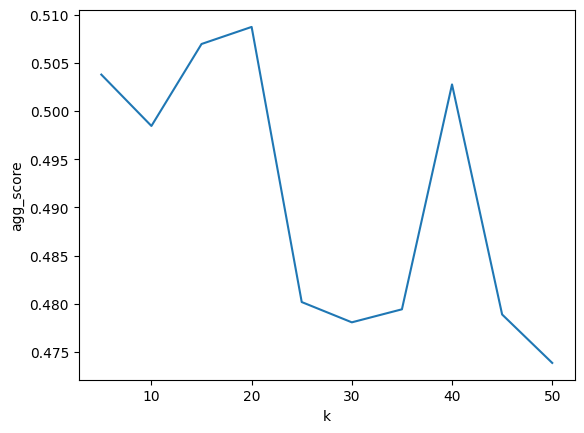

In [130]:
# Result analysis
results = pd.DataFrame({"k": k_values, "agg_score": agg_scores})
_=sns.lineplot(data=results, x="k", y="agg_score")

In [132]:
results.sort_values("agg_score", ascending=False)

,k,agg_score
3,20,0.508743
2,15,0.506971
0,5,0.503796
7,40,0.502774
1,10,0.498462
4,25,0.480186
6,35,0.479432
8,45,0.478895
5,30,0.478080
9,50,0.473867


---

## Conclusions

- The method using residuals from rating matrix reconstruction is more efficient in giving more customized domains recommendations
- The optimal value for **k** is **20**